# Davide Marchi
## Assignment 4 - Bayesian Network (BN)
_Implement a Bayesian Network (BN) comprising at least 10 nodes, all with binomial or multinomial distribution. Represent the BN with the data structures that you deem appropriate and in the programming language that you prefer. The BN should model some problem/process of your choice, so you are also free to define the topology according to your prior knowledge (just be ready to justify your choices). [...]<br>
Once you have modelled the BN, also plug in the necessary local conditional probability tables. You can set the values of the probabilities following your own intuition on the problem (ie no need to learn them from data). Then run some episoded of Ancestral Sampling on the BN and discuss the results.[...]_

### Imported modules
The realization of the Bayesian Network starts by importing two necessary modules: `random` and `itertools`:<br>
The first one will be needed to randomly generate the samples during ancestral sampling with the function `random()`, while `itertools` will be usuful to create a list of all the possible permutations of the states of the parents of a node with `product()`.

In [81]:
# Import librarires
import random
import itertools

### Bayesian Network class
I have then implemented the `BayesianNetwork` class, which represents a Directed Acyclic Graph (DAG) whose nodes are random variables and the edges describe the conditional independence relationships.

The nodes are stored in the network as a dictionary (`self.nodes`) where the keys are the names of the nodes and the values are dictionaries that contain the node's essential information.

The values of the `self.nodes` dictionaries are dictionaries that contain the following keys:
- `states`: Corresponds to a list of the possible states that the node can take.
- `parents`: Corresponds to a list of the node's parent nodes.
- `cpt`: Corresponds to the node's Conditional Probability Table (CPT).

It's important to note that the CPTs are dictionaries too:
- The keys of a CPT dictionary are tuples representing the states of the parents nodes. If a node has no parents, the key will be an empty tuple `()`.
- The values of the CPT dictionary are lists representing the probabilities of the node's states (given the parents' states). The order of the probabilities in the list corresponds to the order of the states in the node's states list.

This structure is based on nested dictionaries, which may appear confusing initially, but they enable efficient lookups and modifications of the nodes, thanks to their implementation as hash maps. Furthermore, later in the notebook, an instance of `BayesianNetwork` will be created and printed to provide further clarification.

In [82]:
# Define the Bayesian Network class
class BayesianNetwork:
    def __init__(self):
        self.nodes = {}
    
    # Add a node to the network after checking for validity
    def add_node(self, name, states, cpt, parents=[]):

        # Check if the node already exists in the network
        if name in self.nodes:
            print(f"Node '{name}' already exists in the network.")
            return
        
        # Check if the node has at least one state
        if len(states) == 0:
            print(f"Node '{name}' must have at least one state.")
            return
        
        # Check if all parent nodes exist in the network
        for parent in parents:
            if parent not in self.nodes:
                print(f"Parent node '{parent}' does not exist in the network.")
                return

        # Check if the Condition Probability Table is valid
        for parent_combination in itertools.product(*[self.nodes[parent]['states'] for parent in parents]):

            # Check if all the possible permutations of the states of the parent nodes are in the CPT
            # Check if each entry in the cpt has the corrent number of probabilities and the sum of the probabilities is 1
            # Note: round(sum(cpt[parent_combination]), 10) is used to avoid floating point errors
            if parent_combination not in cpt or len(cpt[parent_combination]) != len(states) or round(sum(cpt[parent_combination]), 10) != 1:
                print(f"Invalid CPT for node '{name}'.")
                return

        # Add the node to the network
        self.nodes[name] = {'states': states, 'parents': parents, 'cpt': cpt}
    
    # Retrieve the probability of a state of a node given its parents' states
    def probability(self, node, parent_states, state):
        states = self.nodes[node]['states']
        return self.nodes[node]['cpt'][parent_states][states.index(state)]
    
    # Sample a state for a node given its parents' states
    def sample(self, node, parent_states):

        # Generating a random value and collecting the possible states of the node
        p = random.random()
        cumulative_prob = 0
        states = self.nodes[node]['states']

        # Loop through the possible states of the node and retrieve the probability of each state
        for state in states:
            probability = self.probability(node, parent_states, state)
            cumulative_prob += probability

            # Return the state and its probability if the random value is less than the cumulative probability (= if the state is selected)
            if p <= cumulative_prob:
                return state, probability
    
    # Sample states for all nodes knowing their parents' states
    def sample_states(self):
        sampled_states = {}
        joint_probability = 1

        # Loop through all nodes (in a topological order) and sample the state of each node
        for node in self.nodes:
            parents = self.nodes[node]['parents']
            parent_states = tuple(sampled_states[parent] for parent in parents)
            sampled_states[node], probaility = self.sample(node, parent_states)
            joint_probability *= probaility

        # Return the sampled states saved in a dictionary and the joint probability
        return sampled_states, joint_probability

"Note that while adding a node to the network, several checks are performed to preserve the proper behavior of the BN.<br>
The name is checked to ensure it is unique, the CPT must have proper values (the correct number of probabilities and their sum must be equals to 1), and most importantly, I check if all the possible permutations of the states of the parents are present (as tuples) as keys of the CPT.

Furthermore, checking if the parents are already present in the network rquires the user to insert them following a __topological order__. This allows to perform ancestral sampling of the node just by sampling each one at a time from the `nodes` list without having to rearrange them, because each node will be automatically sampled before its descendants.

### Network example
To show the functionality of the presented implementation, here is an example of a possible object of the `BayesianNetwork` class.<br>
I decided to test the class by modeling the Bayesian Network to estimate the overall enjoyment of a concert by the attendees based on the states of some correlated variables.

Below is the graph we are going to implement:
![DAG_Concert_Enjoyment.png](DAG_Concert_Enjoyment.png)

The first step, of course, is to instantiate an object of the `BayesianNetwork` class:

In [83]:
# Define the Bayesian Network for concert enjoyment
concert_bn = BayesianNetwork()

The folling step consists in adding nodes to the network with their respective Conditional Probability Tables.<br>
The topology can be implemented and explained as follow:

1. **MusicGenre**:
- Represents the type of music being played at the concert, such as Pop, Rock, or Jazz.
- Independent variable, as it's determined by the organizers or performers' preferences rather than external factors.

In [84]:
# Node: MusicGenre
concert_bn.add_node('MusicGenre', ['Pop', 'Rock', 'Jazz'], 
                    {
                        (): [0.5, 0.3, 0.2]
                    })

2. **ArtistFame**:
- Indicates the level of fame of the performing artist, categorized as Unknown, Known, or Superstar.
- Independent variable, as it's typically known before the concert and doesn't rely on other factors within the Bayesian Network.

In [85]:
# Node: ArtitstFame
concert_bn.add_node('ArtistFame', ['Unknown', 'Known', 'Superstar'], 
                    {
                        (): [0.3, 0.5, 0.2]
                    })

3. **ArtistPerformance**:
- Reflects the quality of the artist's performance, categorized as Poor, Average, or Excellent.
- Depends on the ArtistFame variable, as we expect a better performance from artists who are more notorious and popular.

In [86]:
# Node: ArtistPerformance
concert_bn.add_node('ArtistPerformance', ['Poor', 'Average', 'Excellent'], 
                    {
                        ('Unknown',): [0.5, 0.4, 0.1],
                        ('Known',): [0.3, 0.5, 0.2],
                        ('Superstar',): [0.1, 0.2, 0.7]
                    },
                    parents=['ArtistFame'])

4. **VenueAtmosphere**:
- Describes the atmosphere of the concert venue, characterized as Dull, Energetic, or Electrifying.
- Depends on the MusicGenre variable, as different music genres often evoke different atmospheres within concert venues. (Jazz, for example, leaves a lot of space for improvisation. This can be both spectacular and risky, especially if the improvisation doesn't turn out well).

In [87]:
# Node: VenueAtmosphere
concert_bn.add_node('VenueAtmosphere', ['Dull', 'Energetic', 'Electrifying'], 
                    {
                        ('Rock',): [0.1, 0.4, 0.5],
                        ('Jazz',): [0.4, 0.2, 0.4],
                        ('Pop',): [0.1, 0.6, 0.3]
                    },
                    parents=['MusicGenre'])

5. **CrowdExcitement**:
- Indicates the excitement level of the attending crowd, classified as Low, Moderate, or High.
- Depends on both VenueAtmosphere and ArtistPerformance variables. The atmosphere set by the music genre and the quality of the artist's performance directly influence the crowd's excitement level.

In [88]:
# Node: CrowdExcitement
concert_bn.add_node('CrowdExcitement', ['Low', 'Moderate', 'High'], 
                    {
                        ('Dull', 'Poor'): [0.8, 0.1, 0.1],
                        ('Dull', 'Average'): [0.7, 0.2, 0.1],
                        ('Dull', 'Excellent'): [0.1, 0.5, 0.4],
                        ('Energetic', 'Poor'): [0.4, 0.4, 0.2],
                        ('Energetic', 'Average'): [0.1, 0.5, 0.4],
                        ('Energetic', 'Excellent'): [0.1, 0.2, 0.7],
                        ('Electrifying', 'Poor'): [0.4, 0.5, 0.1],
                        ('Electrifying', 'Average'): [0.1, 0.4, 0.5],
                        ('Electrifying', 'Excellent'): [0.1, 0.1, 0.8]
                    },
                    parents=['VenueAtmosphere', 'ArtistPerformance'])

6. **TicketPrice**:
- Represents the price category of the concert tickets, categorized as Cheap, Moderate, or Expensive.
- Depends on the ArtistFame variable, as artists with higher fame levels might command higher ticket prices due to increased demand.

In [89]:
# Node: TicketPrice
concert_bn.add_node('TicketPrice', ['Cheap', 'Moderate', 'Expensive'], 
                    {
                        ('Unknown',): [0.8, 0.1, 0.1],
                        ('Known',): [0.2, 0.6, 0.2],
                        ('Superstar',): [0.1, 0.2, 0.7]
                    },
                    parents=['ArtistFame'])

7. **WeatherCondition**:
- Describes the weather condition on the day of the concert, classified as Sunny, Cloudy, or Rainy.
- Independent variable, as it's determined by meteorological conditions and doesn't rely on other factors within the Bayesian Network.

In [90]:
# Node: WeatherCondition
concert_bn.add_node('WeatherCondition', ['Sunny', 'Cloudy', 'Rainy'], 
                    {
                        (): [0.4, 0.4, 0.2]
                    })

8. **TravelTime**:
- Indicates the time it takes to travel to the concert venue, categorized as Moderate or Long.
- Depends on the WeatherCondition variable, as adverse weather conditions might lead to longer travel times due to traffic or transportation disruptions.

In [91]:
# Node: TravelTime
concert_bn.add_node('TravelTime', ['Moderate', 'Long'], 
                    {
                        ('Sunny',): [0.9, 0.1],
                        ('Cloudy',): [0.7, 0.3],
                        ('Rainy',): [0.2, 0.8]
                    },
                    parents=['WeatherCondition'])

9. **ConcertExpectations**:
- Reflects the attendee's expectations for the concert, categorized as Low, Moderate, or High.
- Depends on both ArtistFame and TicketPrice variables. Attendees might have higher expectations for concerts featuring more famous artists or with higher-priced tickets.

In [92]:
# Node: ConcertExpectations
concert_bn.add_node('ConcertExpectations', ['Low', 'Moderate', 'High'], 
                    {
                        ('Unknown', 'Cheap'): [0.8, 0.1, 0.1],
                        ('Unknown', 'Moderate'): [0.3, 0.4, 0.3],
                        ('Unknown', 'Expensive'): [0.2, 0.2, 0.6],
                        ('Known', 'Cheap'): [0.5, 0.4, 0.1],
                        ('Known', 'Moderate'): [0.3, 0.5, 0.2],
                        ('Known', 'Expensive'): [0.1, 0.2, 0.7],
                        ('Superstar', 'Cheap'): [0.1, 0.3, 0.6],
                        ('Superstar', 'Moderate'): [0.1, 0.2, 0.7],
                        ('Superstar', 'Expensive'): [0.1, 0.1, 0.8]
                    },
                    parents=['ArtistFame', 'TicketPrice'])

10. **OverallEnjoyment**:
- Represents the overall enjoyment level experienced by the attendee at the concert, categorized as Low, Moderate, or High.
- Depends on the TravelTime, CrowdExcitement, and ConcertExpectations variables. Longer travel times, higher crowd excitement, and meeting or exceeding expectations can lead to higher overall enjoyment levels.

In [93]:
# Node: OverallEnjoyment (Target Variable)
concert_bn.add_node('OverallEnjoyment', ['Low', 'Moderate', 'High'], 
                    {
                        ('Moderate', 'Low', 'Low'): [0.3, 0.6, 0.1],
                        ('Moderate', 'Low', 'Moderate'): [0.5, 0.4, 0.1],
                        ('Moderate', 'Low', 'High'): [0.8, 0.1, 0.1],
                        ('Moderate', 'Moderate', 'Low'): [0.1, 0.3, 0.6],
                        ('Moderate', 'Moderate', 'Moderate'): [0.3, 0.3, 0.4],
                        ('Moderate', 'Moderate', 'High'): [0.2, 0.5, 0.3],
                        ('Moderate', 'High', 'Low'): [0.0, 0.1, 0.9],
                        ('Moderate', 'High', 'Moderate'): [0.1, 0.1, 0.8],
                        ('Moderate', 'High', 'High'): [0.0, 0.2, 0.8],
                        ('Long', 'Low', 'Low'): [0.4, 0.5, 0.1],
                        ('Long', 'Low', 'Moderate'): [0.6, 0.3, 0.1],
                        ('Long', 'Low', 'High'): [0.9, 0.1, 0.0],
                        ('Long', 'Moderate', 'Low'): [0.2, 0.3, 0.5],
                        ('Long', 'Moderate', 'Moderate'): [0.3, 0.4, 0.3],
                        ('Long', 'Moderate', 'High'): [0.3, 0.5, 0.2],
                        ('Long', 'High', 'Low'): [0.1, 0.1, 0.8],
                        ('Long', 'High', 'Moderate'): [0.1, 0.2, 0.7],
                        ('Long', 'High', 'High'): [0.1, 0.1, 0.8],
                    },
                    parents=['TravelTime', 'CrowdExcitement', 'ConcertExpectations'])

Given the nested dictionaries used to store all elements of the Bayesian Network (BN), we can print `concert_bn.nodes` in a formatted manner to clearly visualize the implemented structure.

In [94]:
# Print the nodes in the network in a readable format
import pprint
pprint.pprint(concert_bn.nodes, sort_dicts=False)

{'MusicGenre': {'states': ['Pop', 'Rock', 'Jazz'],
                'parents': [],
                'cpt': {(): [0.5, 0.3, 0.2]}},
 'ArtistFame': {'states': ['Unknown', 'Known', 'Superstar'],
                'parents': [],
                'cpt': {(): [0.3, 0.5, 0.2]}},
 'ArtistPerformance': {'states': ['Poor', 'Average', 'Excellent'],
                       'parents': ['ArtistFame'],
                       'cpt': {('Unknown',): [0.5, 0.4, 0.1],
                               ('Known',): [0.3, 0.5, 0.2],
                               ('Superstar',): [0.1, 0.2, 0.7]}},
 'VenueAtmosphere': {'states': ['Dull', 'Energetic', 'Electrifying'],
                     'parents': ['MusicGenre'],
                     'cpt': {('Rock',): [0.1, 0.4, 0.5],
                             ('Jazz',): [0.4, 0.2, 0.4],
                             ('Pop',): [0.1, 0.6, 0.3]}},
 'CrowdExcitement': {'states': ['Low', 'Moderate', 'High'],
                     'parents': ['VenueAtmosphere', 'ArtistPerformance'],
   

### Ancestral Sampling
To evaluate the capability of performing Ancestral Sampling and test the Bayesian Network, I conducted multiple calls to the `sample_states()` function. By performing a certain number of iterations, we can gather sufficient data to attempt to make assumptions regarding which states are most likely to be reached by the nodes.

In [95]:
# Initializing a list that will contain the overall enjoyment of each episode
OverallEnjoymentList = []

# Cycle to perform multiple episodes of sampling
for i in range(10000):

    # Sample states for all nodes
    sampled_states, joint_probability = concert_bn.sample_states()

    # The commented code can be used to print the sampled states and the joint probability of each episode of Ancestral Sampling
    '''
    # Print sampled states
    for node, state in sampled_states.items():
        print(f"{node}: {state}")

    # Print joint probability
    print(f"Joint Probability: {joint_probability}\n")
    '''
    
    # Append the overall enjoyment to the list
    OverallEnjoymentList.append(sampled_states['OverallEnjoyment'])

After populating the list containing all the states assumed by the variable we have chosen (`OverallEnjoyment`), we can proceed to calculate and visualize some plots depicting the percentage of occurrence of each state. This will allow us to observe which states are more commonly obtained and by what margin.

Of course this type of analysis could be performed on every other node of the Bayesian Network as well if needed.

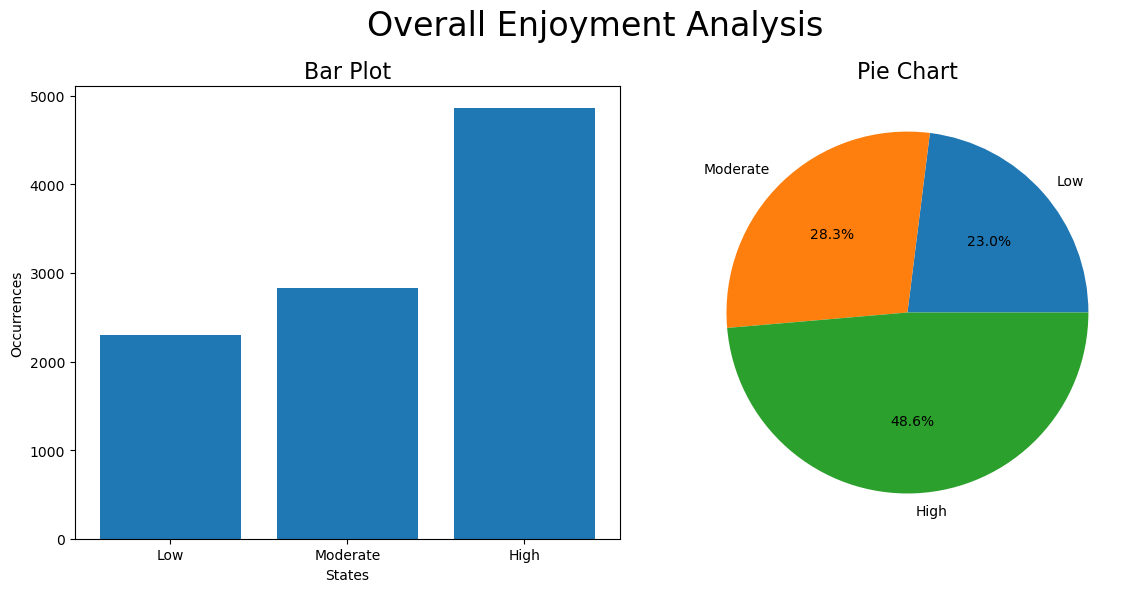

In [96]:
# Import libraries
import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each state
state_counts = Counter(OverallEnjoymentList)

# Define the states (Low, Moderate, High)
states = concert_bn.nodes['OverallEnjoyment']['states']

# Initialize counts for each state
counts = [state_counts.get(state, 0) for state in states]

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Bar plot
axes[0].bar(states, counts)
axes[0].set_xlabel('States')
axes[0].set_ylabel('Occurrences')
axes[0].set_title('Bar Plot', fontsize=16)

# Pie chart
axes[1].pie(counts, labels=states, autopct='%1.1f%%')
axes[1].set_title('Pie Chart', fontsize=16)

plt.suptitle('Overall Enjoyment Analysis', fontsize=24)
plt.tight_layout()
plt.show()

### Results and personal considerations
Upon reviewing the plots generated from 10.000 episodes of Ancestral Sampling, it becomes apparent that overall high enjoyment of the concert is the most probable outcome. However, there's still a chance that some might not enjoy it as much, or at all.

It is essential to acknowledge that these results are based on conditional probability tables (CPTs) crafted by myself with a limited personal experience. As such, they're more of a proof of concept than anything else. Nonetheless, they still suffice to demonstrate that the implmentation of the `BayesianNetwork` can be rightfully instantiated and effectively sampled multiple times in a row.

The use of dictionaries in the implementation enables direct access to nodes and elements of the CPTs, facilitating efficient sampling. Furthermore, this approach offers the potential for repeated sampling to enhance the stability of outcome percentages over multiple runs, thereby improving confidence in the results obtained.

In conclusion, while the current findings may not be considered particularly insightful, further refinement of the CPTs and additional sampling iterations may be warranted to obtain more robust and reliable results.